In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend 
from matplotlib import font_manager
from matplotlib import gridspec
import seaborn as sns
import scanpy as sc
import yaml
from pathlib import Path
import warnings
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

warnings.filterwarnings('ignore')

In [2]:

class single_cell_plots:
    """
        Class to create atlas figures with config yml
    """

    def __init__(self, config_path, output_dir="figures"):
        self.config = self._load_config(config_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self._setup_plotting_params()

    def _load_config(self, config_path):
        """Load configuration from YAML file"""
        if isinstance(config_path, str):
            with open(config_path, 'r') as f:
                return yaml.safe_load(f)
        elif isinstance(config_path, dict):
            return config_path
        else:
            raise ValueError("Config must be a file path or dictionary")

    def _setup_plotting_params(self):
        """Set up matplotlib and scanpy plotting parameters"""
        cfg = self.config['plot_configs']['general']
        plt.rcParams['figure.dpi'] = cfg['dpi']
        plt.rcParams['savefig.dpi'] = cfg['dpi_save']
        plt.rcParams['legend.fontsize'] = cfg['legend_fontsize']
        plt.rcParams['axes.titlesize'] = cfg['title_fontsize']
        sc.settings.set_figure_params(
            dpi_save=cfg['dpi_save'],
            fontsize=cfg['legend_fontsize']
        )

    ##### UMAPs #####

    def create_masked_umap(self, adata, mask_column, mask_values=None,
                           color_by='Level_4', figure_name=None):
        """
        Create masked UMAP plots showing only specified cell populations.
        """
        print(f"Creating masked UMAP plots for {mask_column}")

        if figure_name is None:
            raise ValueError("figure_name must be provided")

        # Create subdirectory for this figure
        dir_name = figure_name.replace(" ", "_")
        figure_dir = self.output_dir / dir_name
        figure_dir.mkdir(parents=True, exist_ok=True)
        sc.settings.figdir = str(figure_dir)

        if not pd.api.types.is_categorical_dtype(adata.obs[color_by]):
            adata.obs[color_by] = adata.obs[color_by].astype("category")

        if mask_values is None:
            mask_values = adata.obs[mask_column].unique().tolist()

        # Create a new column with only the mask_values, others set to 'Other'
        color_col_filtered = f"{color_by}_filtered"
        adata.obs[color_col_filtered] = adata.obs[color_by].astype(str)
        adata.obs.loc[~adata.obs[color_by].isin(mask_values), color_col_filtered] = 'Other'

        # Convert to categorical with mask_values + 'Other'
        categories = list(mask_values) + ['Other']
        adata.obs[color_col_filtered] = pd.Categorical(
            adata.obs[color_col_filtered],
            categories=categories
        )

        #use palette for mask_values, lightgrey for rest ##lightblue if no value found
        palette = self.config['palettes'].get(color_by.lower(), {})
        new_palette = [palette.get(ct, "skyblue") for ct in mask_values] + ["lightgrey"]
        adata.uns[f"{color_col_filtered}_colors"] = new_palette

        # Generate masked UMAP plots
        sc.pl.umap(
            adata,
            color=color_col_filtered,
            legend_loc=None,
            show=False,
            title=figure_name,
            frameon=False,
            save=f"_{dir_name}_masked_colored_{color_by}.png"
        )

        sc.pl.umap(
            adata,
            color=color_col_filtered,
            show=False,
            title=figure_name,
            frameon=False,
            save=f"_{dir_name}_masked_colored_{color_by}_legend.png"
        )

        # Create version without 'Other' in legend ##lightblue if no value found
        adata_subset = adata[adata.obs[color_by].isin(mask_values)].copy()
        adata_subset.obs[color_by] = adata_subset.obs[color_by].cat.remove_unused_categories()

        subset_palette = [palette.get(ct, "skyblue") for ct in adata_subset.obs[color_by].cat.categories]
        adata_subset.uns[f"{color_by}_colors"] = subset_palette

        sc.pl.umap(
            adata_subset,
            color=color_by,
            show=False,
            title=figure_name,
            frameon=False,
            save=f"_{dir_name}_subset_only_{color_by}_legend.png"
        )


    def create_masked_umap_highlight(self, adata, mask_column, mask_values=None,
                      color_by='Level_4', figure_name=None, 
                      highlight_size=3, background_size=0.25):
        """
        Create masked UMAP plots showing only specific cell populations, highlighted cells have bigger dots.
        """
        print(f"Creating masked UMAP plots for {mask_column}")
        if figure_name is None:
            raise ValueError("figure_name must be provided")
        
        # Create subdirectory for this figure
        dir_name = figure_name.replace(" ", "_")
        figure_dir = self.output_dir / dir_name
        figure_dir.mkdir(parents=True, exist_ok=True)
        sc.settings.figdir = str(figure_dir)
        
        if not pd.api.types.is_categorical_dtype(adata.obs[color_by]):
            adata.obs[color_by] = adata.obs[color_by].astype("category")
        
        if mask_values is None:
            mask_values = adata.obs[mask_column].unique().tolist()
        
        # Create filtered color column
        color_col_filtered = f"{color_by}_filtered"
        adata.obs[color_col_filtered] = adata.obs[color_by].astype(str)
        adata.obs.loc[~adata.obs[color_by].isin(mask_values), color_col_filtered] = 'Other'
        
        # Create size column - larger for highlighted cells, smaller for background
        size_col = f"{color_col_filtered}_sizes"
        adata.obs[size_col] = background_size  # default small size
        adata.obs.loc[adata.obs[color_col_filtered] != 'Other', size_col] = highlight_size
        
        # Convert to categorical
        categories = list(mask_values) + ['Other']
        adata.obs[color_col_filtered] = pd.Categorical(
            adata.obs[color_col_filtered],
            categories=categories
        )
        
        # Set up colors
        palette = self.config['palettes'].get(color_by.lower(), {})
        new_palette = [palette.get(ct, "skyblue") for ct in mask_values] + ["lightgrey"]
        adata.uns[f"{color_col_filtered}_colors"] = new_palette
        
        # Generate masked UMAP plots with variable sizes
        sc.pl.umap(
            adata,
            color=color_col_filtered,
            size=adata.obs[size_col], 
            legend_loc=None,
            show=False,
            title=figure_name,
            frameon=False,
            save=f"_{dir_name}_masked_colored_{color_by}_highlight.png"
        )

        sc.pl.umap(
            adata,
            color=color_col_filtered,
            size=adata.obs[size_col], 
            show=False,
            title=figure_name,
            frameon=False,
            save=f"_{dir_name}_masked_colored_{color_by}_legend_highlight.png"
        )

        
##### Compositional plots #####


    def cluster_samples(self,ct_props):
        dist_matrix = pdist(ct_props.values, metric='euclidean')
        linkage_matrix = linkage(dist_matrix, method='ward')
        return ct_props.index[leaves_list(linkage_matrix)]

    def cluster_grouped_samples(self,ct_props, adata, sample_column, order_by_column, order_ascending):
        group_labels = adata.obs.groupby(sample_column)[order_by_column].first().sort_values(ascending=order_ascending)
        grouped_samples = []
        for group_value in group_labels.unique():
            group_sample_ids = group_labels[group_labels == group_value].index
            group_props = ct_props.loc[group_sample_ids]
            if len(group_props) > 1:
                d = pdist(group_props.values, metric='euclidean')
                link = linkage(d, method='ward')
                cluster_idx = leaves_list(link)
                ordered_samples = group_props.index[cluster_idx]
            else:
                ordered_samples = group_props.index
            grouped_samples.extend(ordered_samples)
        return grouped_samples

    def plot_barplot(self,ct_props, color_dict, title, ylabel, figsize, sample_column, order_values=None, order_color_dict=None, order_by_column=None):
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(ct_props))
        for cell_type in ct_props.columns:
            values = ct_props[cell_type].values
            clean_label = cell_type.replace("Malignant Cell - ", "")
            ax.bar(range(len(ct_props)), values, bottom=bottom,
                color=color_dict.get(cell_type, 'gray'), label=clean_label,
                edgecolor='white', linewidth=1.0)
            bottom += values

        ax.set_xlabel(sample_column.replace('_', ' ').title(), fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(title, fontsize=self.config["plot_configs"]["general"]["title_fontsize"], fontweight=self.config["plot_configs"]["general"]["title_fontweight"], pad=20)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
        ax.set_xlim(-0.5, len(ct_props) - 0.5)
        ax.set_ylim(0, 1.0)
        ax.set_axisbelow(True)

        if order_values and order_color_dict:
            bar_height = 0.03
            for i, val in enumerate(order_values):
                ax.barh(y=-bar_height/2, width=1, left=i-0.5, height=bar_height, 
                        color=order_color_dict[val], clip_on=False)
            ax.set_ylim(-bar_height, 1.0)

        # Add legends to right of plot
        handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[key]) for key in ct_props.columns]
        labels = [key.replace("Malignant Cell - ", "") for key in ct_props.columns]
        legend1 = ax.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc='upper left', title="Cell Types",title_fontproperties=font_manager.FontProperties(weight='bold'),fontsize=self.config["plot_configs"]["general"]["legend_fontsize"])
        ax.add_artist(legend1)

        if order_color_dict and order_by_column:
            order_handles = [plt.Rectangle((0, 0), 1, 1, color=order_color_dict[val]) for val in order_color_dict]
            order_labels = [str(val) for val in order_color_dict]
            legend2 = ax.legend(order_handles, order_labels, bbox_to_anchor=(1.01, 0), loc='lower left', title=order_by_column.replace('_', ' ').title())
            legend2.get_title().set_fontweight('bold')

        plt.subplots_adjust(right=0.95)
        return fig

    def create_all_stacked_barplots(self, adata, level_column, sample_column="Sample_ID", 
                                    subset_level=None, subset_value=None,
                                    order_by_column=None, order_ascending=True,
                                    figsize=(16, 8), save_name_prefix="composition"):
        if sample_column is None:
            for col in adata.obs.columns:
                if adata.obs[col].dtype in ['object', 'category']:
                    sample_column = col
                    break
            else:
                raise ValueError("No suitable sample column found.")

        if subset_level and subset_value:
            if isinstance(subset_value, str):
                subset_value = [subset_value]
            adata = adata[adata.obs[subset_level].isin(subset_value), :]

        if level_column not in adata.obs.columns or sample_column not in adata.obs.columns:
            raise ValueError("Required columns not found.")

        ct_data = pd.crosstab(adata.obs[sample_column], adata.obs[level_column])
        ct_props = ct_data.div(ct_data.sum(axis=1), axis=0)

        color_dict = self.config["palettes"]["level_4"]
        ylabel = f"Cell Type Proportion ({subset_value[0]}s)" if subset_value else "Cell Type Proportion"
        title_base = f"Cell Type Composition by {sample_column.replace('_', ' ').title()}"

        figs = {}
        order_color_dict = None
        order_values_basic = None

        if order_by_column and order_by_column in adata.obs.columns:
            order_values_basic = [adata.obs[adata.obs[sample_column] == s][order_by_column].iloc[0] for s in ct_props.index]
            unique_vals = list(dict.fromkeys(order_values_basic))
            cmap = plt.cm.Set3(np.linspace(0, 1, len(unique_vals)))
            order_color_dict = dict(zip(unique_vals, cmap))

        # Basic
        figs["basic"] = self.plot_barplot(ct_props, color_dict, f"{title_base}", ylabel, figsize, sample_column, order_values_basic, order_color_dict, order_by_column)

        # Clustered
        clustered_order = self.cluster_samples(ct_props)
        order_values_clustered = [adata.obs[adata.obs[sample_column] == s][order_by_column].iloc[0] for s in ct_props.loc[clustered_order].index] if order_color_dict else None
        figs["clustered"] = self.plot_barplot(ct_props.loc[clustered_order], color_dict, f"{title_base} (Clustered)", ylabel, figsize, sample_column, order_values_clustered, order_color_dict, order_by_column)

        # Grouped Clustered
        if order_by_column and order_by_column in adata.obs.columns:
            grouped_order = self.cluster_grouped_samples(ct_props, adata, sample_column, order_by_column, order_ascending)
            order_values_grouped = [adata.obs[adata.obs[sample_column] == s][order_by_column].iloc[0] for s in ct_props.loc[grouped_order].index]
            figs["clustered_grouped"] = self.plot_barplot(ct_props.loc[grouped_order], color_dict, f"{title_base} (Clustered per Group)", ylabel, figsize, sample_column, order_values_grouped, order_color_dict, order_by_column)

        # Save plots
        save_dir = self.output_dir / "compositional_plot"
        save_dir.mkdir(parents=True, exist_ok=True)
        for key, fig in figs.items():
            ax = fig.axes[0]
            legends = [artist for artist in ax.get_children() if isinstance(artist, Legend)]
            fig.savefig(save_dir / f"{save_name_prefix}_{key}.png",
                        dpi=self.config['plot_configs']['general']['dpi_save'],
                        bbox_inches='tight',
                        bbox_extra_artists=legends,
                        facecolor='white')

        return figs



    def composition_heatmap(self, adata, level_column, sample_column="Sample_ID", 
                        subset_level=None, subset_value=None, 
                        order_by_column=None, figsize=(16, 6), 
                        title=None, save_name=None, **kwargs):


        if sample_column is None:
            if 'sample' in adata.obs.columns:
                sample_column = 'sample'
            else:
                for col in adata.obs.columns:
                    if adata.obs[col].dtype in ['object', 'category']:
                        sample_column = col
                        break
                else:
                    raise ValueError("No suitable sample column found. Please specify sample_column.")

        # Subset
        if subset_level is not None and subset_value is not None:
            if subset_level not in adata.obs.columns:
                raise ValueError(f"Subset level '{subset_level}' not found in adata.obs")
            if isinstance(subset_value, str):
                subset_value = [subset_value]
            mask = adata.obs[subset_level].isin(subset_value)
            adata = adata[mask, :]
            print(f"Subset to {mask.sum()} cells with {subset_level} in {subset_value}")

        if level_column not in adata.obs.columns or sample_column not in adata.obs.columns:
            raise ValueError("Required columns not found in adata.obs")
        if order_by_column and order_by_column not in adata.obs.columns:
            raise ValueError(f"Order column '{order_by_column}' not found in adata.obs")

        # Compute proportions
        ct_data = pd.crosstab(adata.obs[sample_column], adata.obs[level_column])
        ct_props = ct_data.div(ct_data.sum(axis=1), axis=0)

        # Cluster samples using Euclidean distance
        dist_matrix = pdist(ct_props.values, metric='euclidean')
        linkage_matrix = linkage(dist_matrix, method='ward')
        ordered_indices = leaves_list(linkage_matrix)
        ct_props = ct_props.iloc[ordered_indices]

        # Get order_by_column values for coloring
        if order_by_column:
            order_values = [adata.obs[adata.obs[sample_column] == s][order_by_column].iloc[0] for s in ct_props.index]
            unique_vals = list(dict.fromkeys(order_values))
            order_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_vals)))
            order_color_dict = dict(zip(unique_vals, order_colors))
            order_bar_colors = [order_color_dict[val] for val in order_values]
        else:
            order_bar_colors = None

        # Plot heatmap
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(ct_props.T, annot=False, cmap=self.config["plot_configs"]["continuous_plots"]["cmap"], ax=ax, cbar=True, **kwargs, 
            linewidths=0, linecolor='white', 
            xticklabels=False, yticklabels=True, 
            square=False)

        ax.set_aspect('auto') 


        ax.set_title(title or 'Cell Type Composition (Clustered)', fontsize=self.config["plot_configs"]["general"]["title_fontsize"], fontweight=self.config["plot_configs"]["general"]["title_fontweight"])
        ax.set_xlabel('')
        ax.set_ylabel(f"Cell Types ({subset_value[0]}s)", fontsize=12)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels(ct_props.columns, rotation=0)

        # Color bar below heatmap
        if order_by_column:
            bar_height = 0.2
            for idx, color in enumerate(order_bar_colors):
                ax.add_patch(plt.Rectangle((idx, ct_props.shape[1] + 0.05), 1, bar_height,
                                        color=color, transform=ax.transData, clip_on=False))

            # Add legend below plot
            legend_handles = [plt.Rectangle((0, 0), 1, 1, color=order_color_dict[val]) for val in unique_vals]
            legend_labels = [str(val) for val in unique_vals]
            fig.legend(legend_handles, legend_labels,
                    title=order_by_column.replace("_", " ").title(),
                    loc='lower center', bbox_to_anchor=(0.5, -0.12),
                    ncol=len(unique_vals), fontsize=self.config["plot_configs"]["general"]["legend_fontsize"], title_fontsize=self.config["plot_configs"]["general"]["legend_fontsize"], frameon=False)

        # Adjust layout for legend space
        plt.tight_layout(rect=[0, 0.01, 1, 1])

        # Save
        if save_name is not None:
            save_dir = self.output_dir / "compositional_plot"
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = save_dir / f"{save_name}.png"
            fig.savefig(save_path, dpi=self.config['plot_configs']['general']['dpi_save'],
                        bbox_inches='tight', facecolor='white')
            print(f"Figure saved to: {save_path}")

        return fig
    
    ##### Dataset overview plots #####

    def sample_and_cell_counts_barplot(self, adata, level_column, sample_column="Sample_ID",
                                figsize=(10, 5), title=None, save_name=None, custom_palette=False):

        if level_column not in adata.obs.columns or sample_column not in adata.obs.columns:
            raise ValueError(f"Columns '{level_column}' and/or '{sample_column}' not found in adata.obs.")

        # Counts
        sample_counts = adata.obs.groupby(level_column)[sample_column].nunique()
        cell_counts = adata.obs[level_column].value_counts()

        # Sort by number of samples
        sorted_categories = sample_counts.sort_values(ascending=False).index.tolist()
        sample_counts = sample_counts.reindex(sorted_categories)
        cell_counts = cell_counts.reindex(sorted_categories)

        # Palette
        if custom_palette:
            try:
                color_dict = self.config["palettes"][level_column]
                colors = [color_dict[cat] for cat in sorted_categories]
            except KeyError:
                raise ValueError(f"Custom palette not found for level '{level_column}' in config['palettes']")
        else:
            palette = sns.color_palette("pastel", len(sorted_categories))
            color_dict = dict(zip(sorted_categories, palette))
            colors = [color_dict[cat] for cat in sorted_categories]

        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])
        axs = []

    
        ax = fig.add_subplot(gs[:, 0])
        ax.bar(sorted_categories, sample_counts.values, color=colors)
        ax.set_title("Samples per Category",
                    fontsize=self.config["plot_configs"]["general"]["title_fontsize"],
                    fontweight=self.config["plot_configs"]["general"]["title_fontweight"])
        ax.set_ylabel("Number of Samples", fontsize=12)
        ax.set_xlabel(level_column.replace("_", " ").title(), fontsize=12,labelpad=10)
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='both', width=1.8)
        [sp.set_linewidth(1.8) for sp in ax.spines.values()]
        ax.grid(False)

       
        ax = fig.add_subplot(gs[:, 1])
        ax.bar(sorted_categories, cell_counts.values, color=colors)
        ax.set_title("Cells per Category",
                    fontsize=self.config["plot_configs"]["general"]["title_fontsize"],
                    fontweight=self.config["plot_configs"]["general"]["title_fontweight"])
        ax.set_ylabel("Number of Cells", fontsize=12)
        ax.set_xlabel(level_column.replace("_", " ").title(), fontsize=12)
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='both', width=1.8)
        [sp.set_linewidth(1.8) for sp in ax.spines.values()]
        ax.grid(False)


        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # Save
        if save_name is not None:
            save_dir = self.output_dir / "sample_cell_counts"
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = save_dir / f"{save_name}.png"
            fig.savefig(save_path, dpi=self.config['plot_configs']['general']['dpi_save'],
                        bbox_inches='tight', facecolor='white')
            print(f"Figure saved to: {save_path}")

        return fig

In [ ]:
#adata = sc.read_h5ad("/mnt/storage/Daniele/atlases/mouse/Mouse_Atlas_Harmonised_PP_updated_annot.h5ad")
adata = sc.read_h5ad("/mnt/storage/Daniele/atlases/mouse/Mouse_Atlas_Harmonised.h5ad")


In [ ]:
print(adata.obs["Dataset"].unique())

['in_house', 'Chen_2024', 'Donahue_2024', 'Rupert_2025', 'Chen_2021', 'Carstens_2021', 'Han_2023', 'Erdem_2024']
Categories (8, object): ['Carstens_2021', 'Chen_2021', 'Chen_2024', 'Donahue_2024', 'Erdem_2024', 'Han_2023', 'Rupert_2025', 'in_house']


In [ ]:
adata.obs["Model"] = adata.obs["Model"].replace("implantation", "orthotopic")

In [ ]:
adata

AnnData object with n_obs × n_vars = 602670 × 32479
    obs: 'Sample_ID', 'Condition', 'Treatment', 'TreatmentType', 'TreatmentStatus', 'Tissue', 'Sex', 'Dataset', 'Technology', 'Level_1', 'Level_2', 'Level_3', 'Level_4', 'Model', 'Barcoded', 'Strain', 'Genotype', 'Larry_positive', 'Provenance'
    var: 'manual_gene'
    uns: 'Level_1_final_colors', 'Level_1_refined_colors', 'Level_2_final_colors', 'Level_3_colors', 'Level_3_final_colors', 'Level_4_final_colors', 'Level_4_knn_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'Cell_filtering', 'DRVI_emb', 'X_pca', 'X_scANVI', 'X_umap', 'X_umap_circle', 'batch', 'bin_edges', 'expiMAP_emb', 'leiden', 'leiden_0.5', 'leiden_1.0', 'leiden_1.5', 'leiden_endothelial_level_1', 'leiden_epithelial_level_1', 'leiden_fibroblast_level_1', 'leiden_lymphoid_level_1', 'leiden_myeloid_level_1', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_hb', 'log1p_total_counts_malat', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_genes_

In [ ]:

figgen = single_cell_plots("config.yml",output_dir="/mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/figure5")



In [ ]:
masked_plot = {
    "CD4+ T Cells": ["CD4+ Naive T Cell", "CD4+ Th1 Cell", "CD4+ Th2 Cell", "CD4+ Th17 Cell",
            "CD4+ Th22 Cell", "T-reg", "CD4+ Memory T Cell"],
    "CD8+ T Cells": ["CD8+ Naive T Cell", "CD8+ Effector T Cell", "CD8+ Terminal Effector T Cell",
            "CD8+ Exhausted T Cell", "CD8+ Tissue-Resident Memory T Cell", "CD8+ Memory T Cell"],
    "Mixed T Cells": ["Double Positive CD4+CD8+ T Cell", "γδ T Cell (Vδ1)"],
    "Malignant Cells": ["Malignant Cell - Pit Like", "Malignant Cell - Acinar-like", "Malignant Cell - Epithelial",
            "Malignant Cell - Hypoxia", "Malignant Cell - EMT", "Malignant Cell - Highly Proliferative",
            "Malignant Cell - Mesenchymal", "Malignant Cell - Highly Invasive", "Malignant Cell - Senescence",
            "Malignant Cell - Apoptotic"],
    "Macrophages": ["Macrophage - lipid processing TAM", "Macrophage - antigen processing TAM",
            "Macrophage - C1Q+ TAM", "Macrophage - angiogenic TAM", "Macrophage - CD3+ TAM"],
    "Neutrophils": ["Neutrophil - N0", "Neutrophil - N1", "Neutrophil - N2"],
            "Dendritic cells": ["Dendritic Cell - pDC", "Dendritic Cell - cDC1", "Dendritic Cell - cDC2"]     
}

for figure_name, mask_values in masked_plot.items():
    figgen.create_masked_umap_highlight(adata, mask_column="Level_4", figure_name=figure_name, mask_values=mask_values)
    figgen.create_masked_umap(adata, mask_column="Level_4", figure_name=figure_name, mask_values=mask_values)


Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4
Creating masked UMAP plots for Level_4


In [ ]:
figgen.create_masked_umap_highlight(adata, mask_column="Model", figure_name="Orthotopic Model", mask_values=["orthotopic"],color_by="Model")
figgen.create_masked_umap_highlight(adata, mask_column="Model", figure_name="Endogenous Model", mask_values=["endogenous"],color_by="Model")
figgen.create_masked_umap_highlight(adata, mask_column="Larry_positive", figure_name="pLarry detection", mask_values=["True"],color_by="Larry_positive")
figgen.create_masked_umap_highlight(adata, mask_column="TreatmentStatus", figure_name="Treatment Status", mask_values=["Treated"],color_by="TreatmentStatus")
figgen.create_masked_umap_highlight(adata, mask_column="Dataset", figure_name="in_house", mask_values=["in_house"],color_by="Dataset")



Creating masked UMAP plots for Model
Creating masked UMAP plots for Model
Creating masked UMAP plots for Larry_positive
Creating masked UMAP plots for TreatmentStatus
Creating masked UMAP plots for Dataset


Figure saved to: /mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/figure5/sample_cell_counts/sample_cell_counts_dataset.png


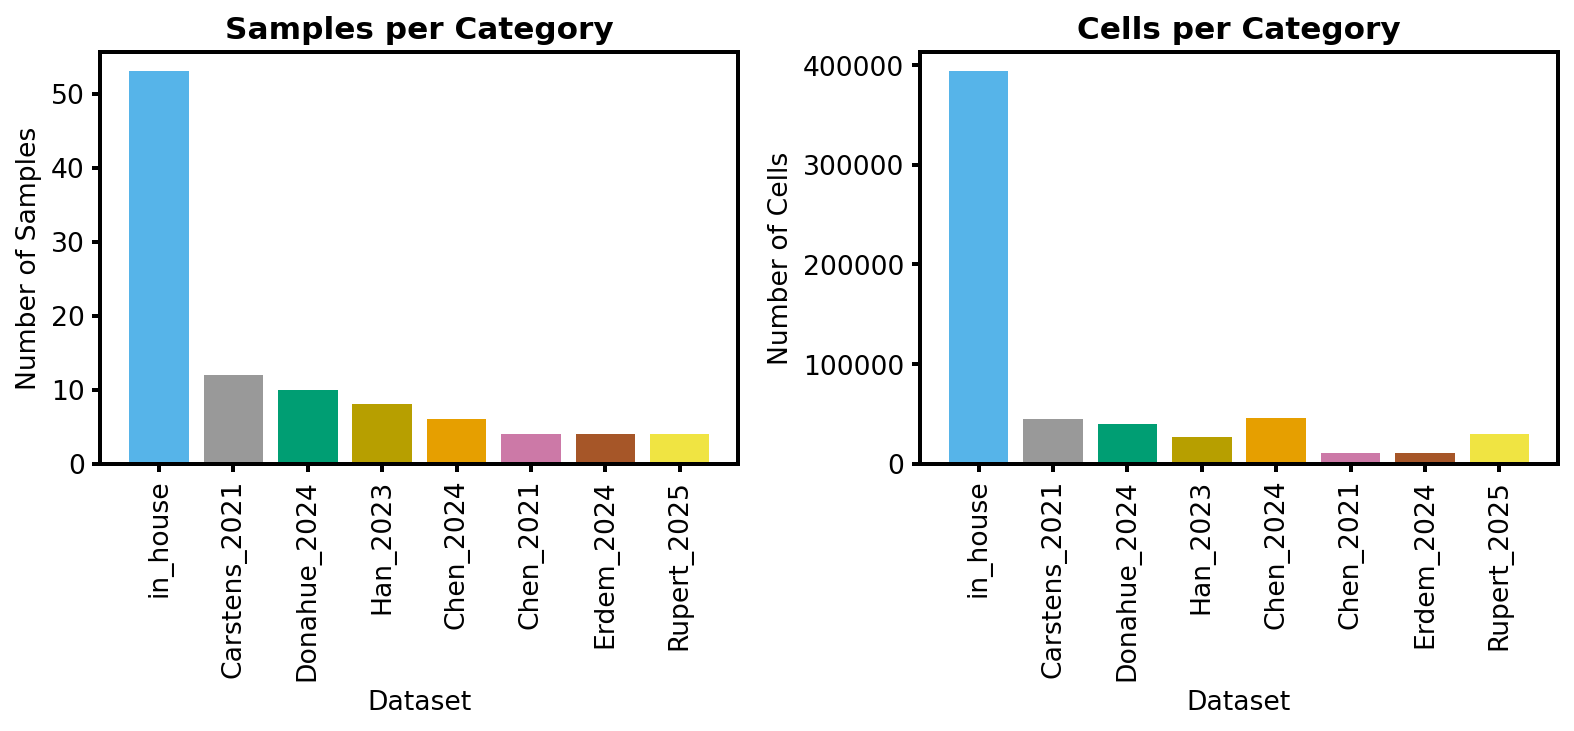

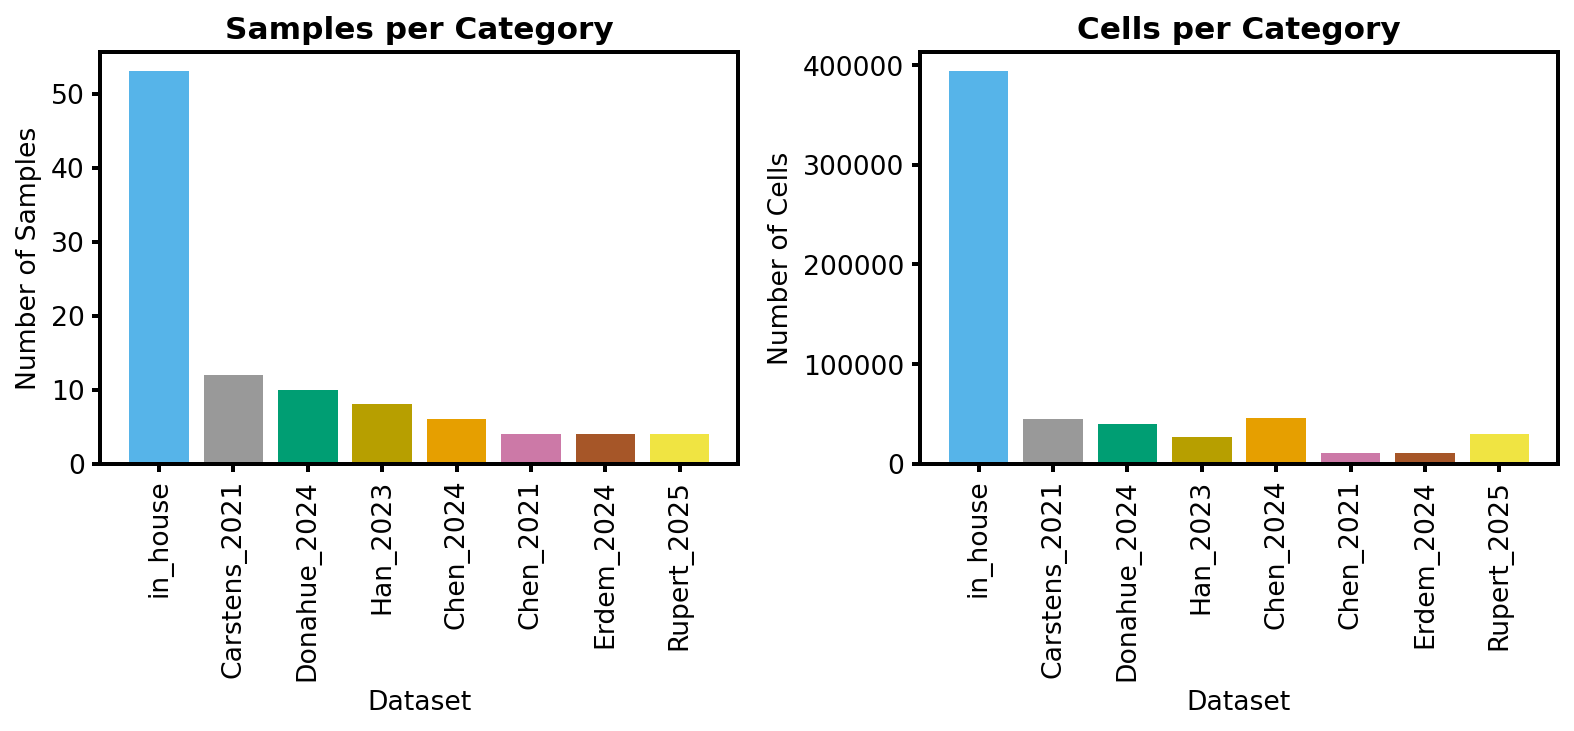

In [ ]:
figgen.sample_and_cell_counts_barplot(
    adata,
    level_column="Dataset",
    sample_column="Sample_ID",
    save_name="sample_cell_counts_dataset",
    custom_palette=True
)


Figure saved to: /mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/figure5/sample_cell_counts/sample_cell_counts_treatment.png


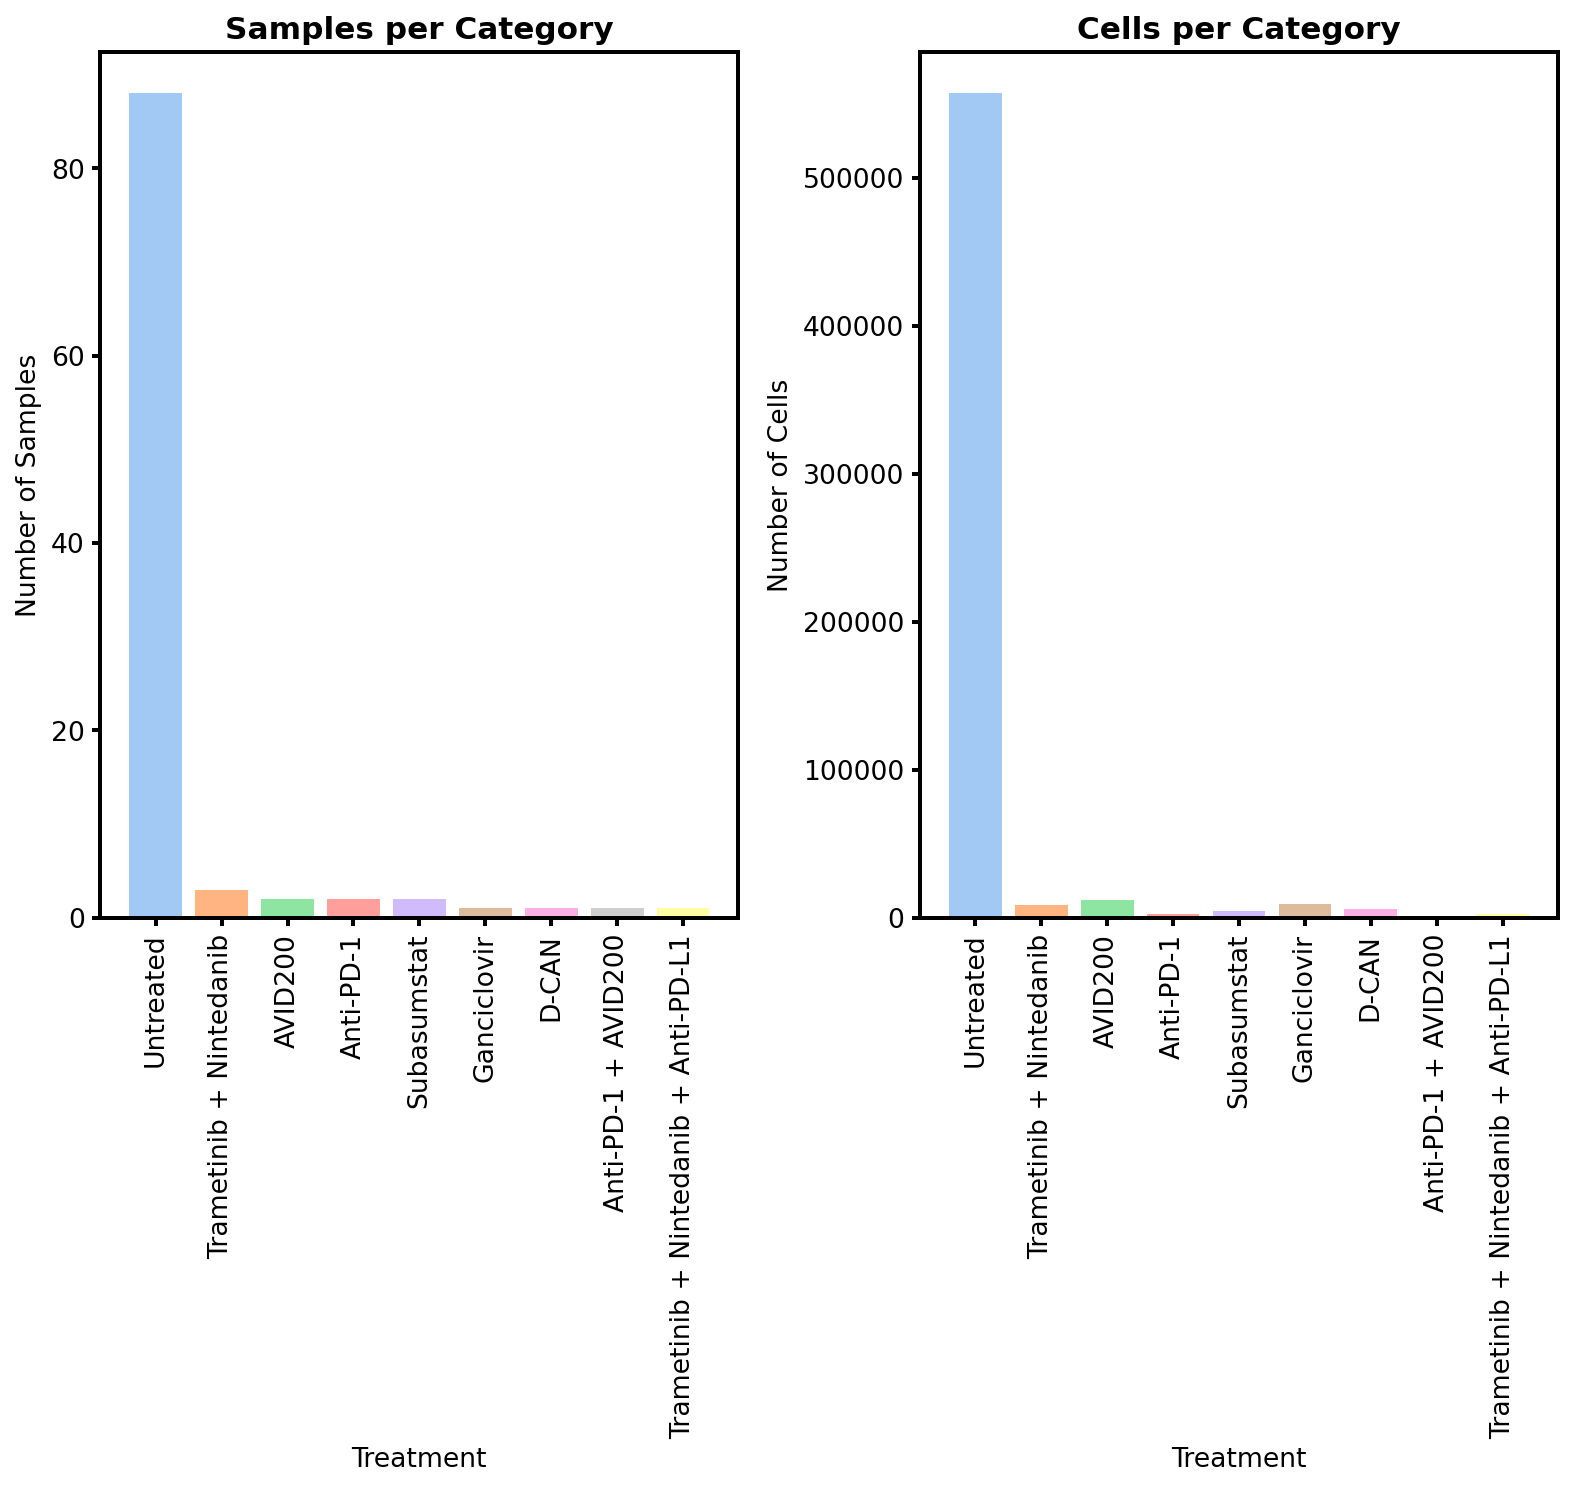

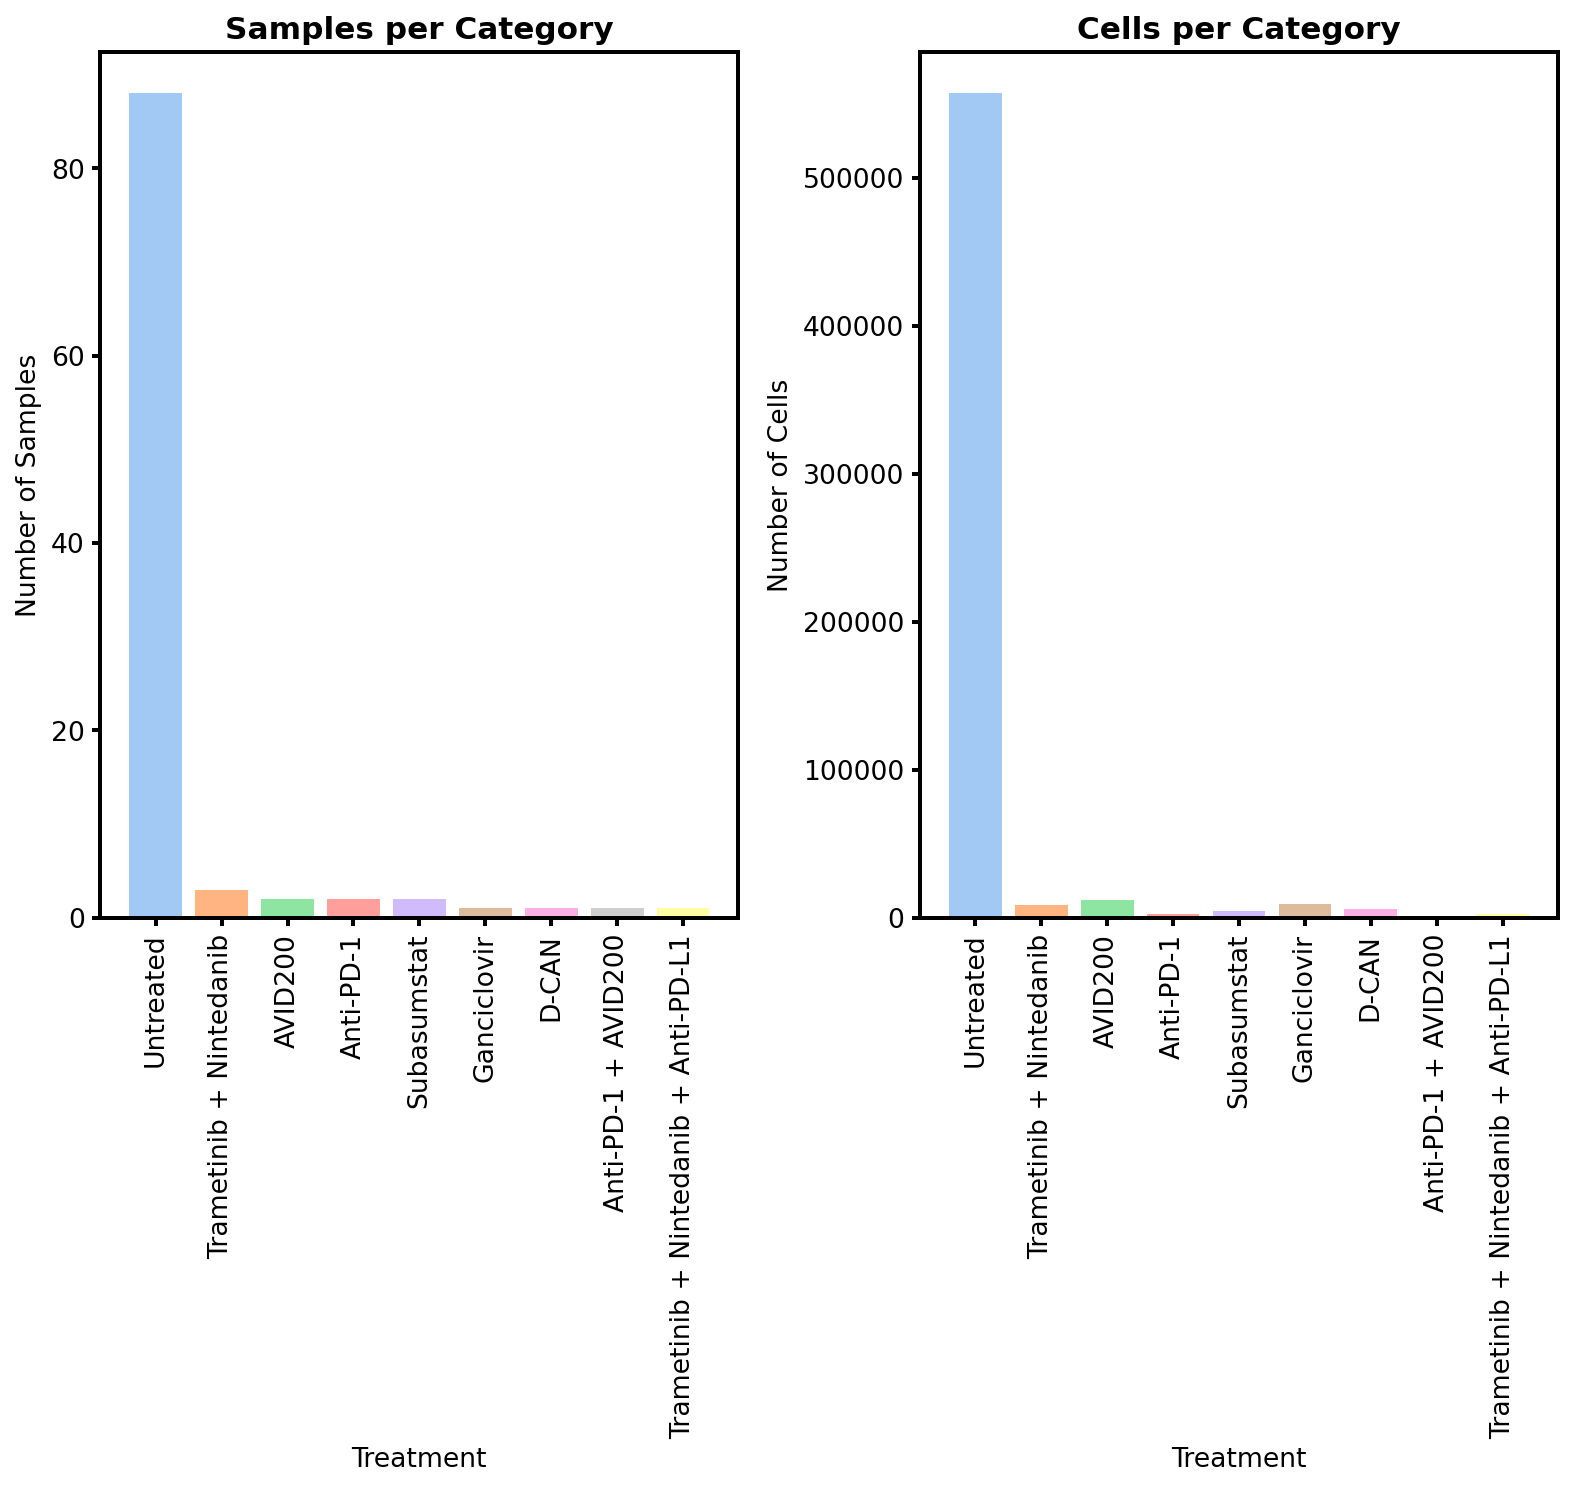

In [ ]:
figgen.sample_and_cell_counts_barplot(
    adata,
    level_column="Treatment",
    sample_column="Sample_ID",
    save_name="sample_cell_counts_treatment",
    figsize=(10,10)
)


Figure saved to: /mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/figure5/sample_cell_counts/sample_cell_counts_treatment_status.png


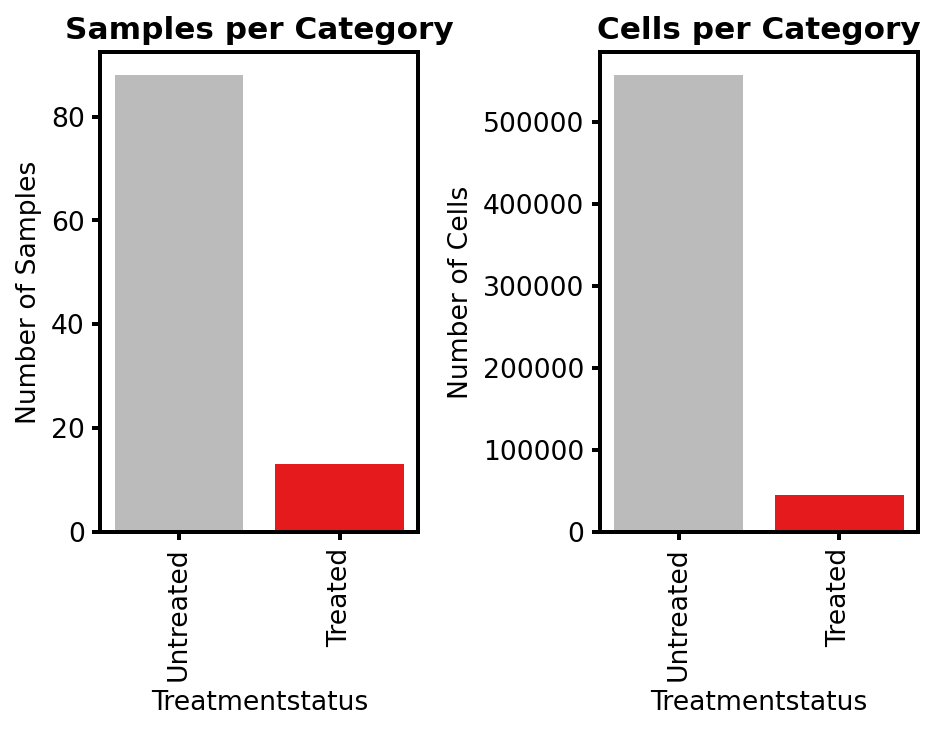

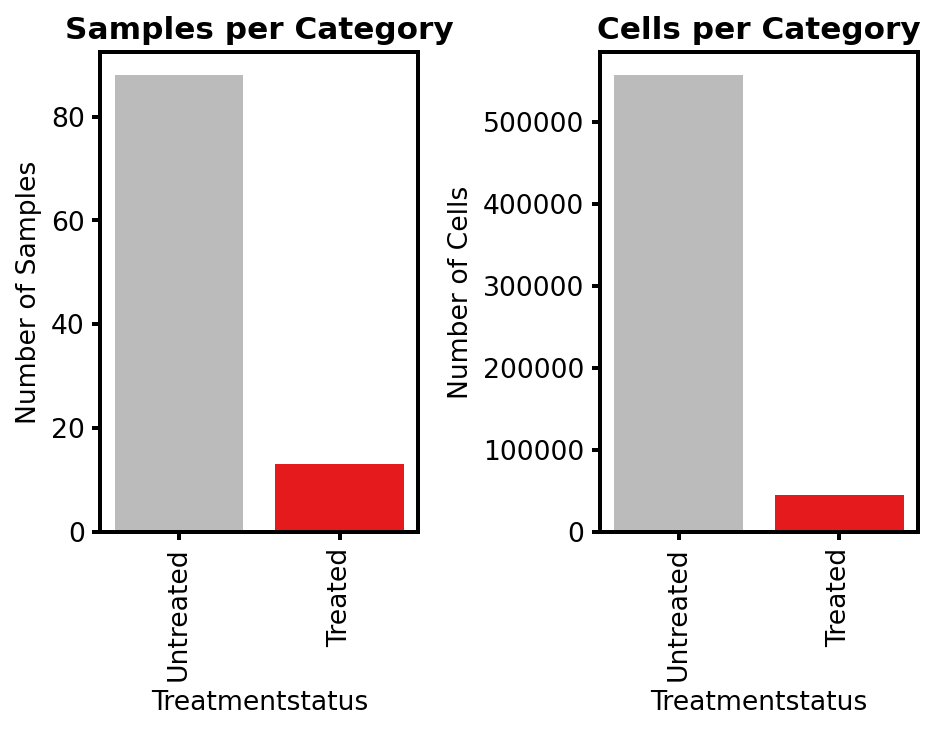

In [ ]:
figgen.sample_and_cell_counts_barplot(
    adata,
    level_column="TreatmentStatus",
    sample_column="Sample_ID",
    save_name="sample_cell_counts_treatment_status",
    figsize=(6,5),
    custom_palette=True
)

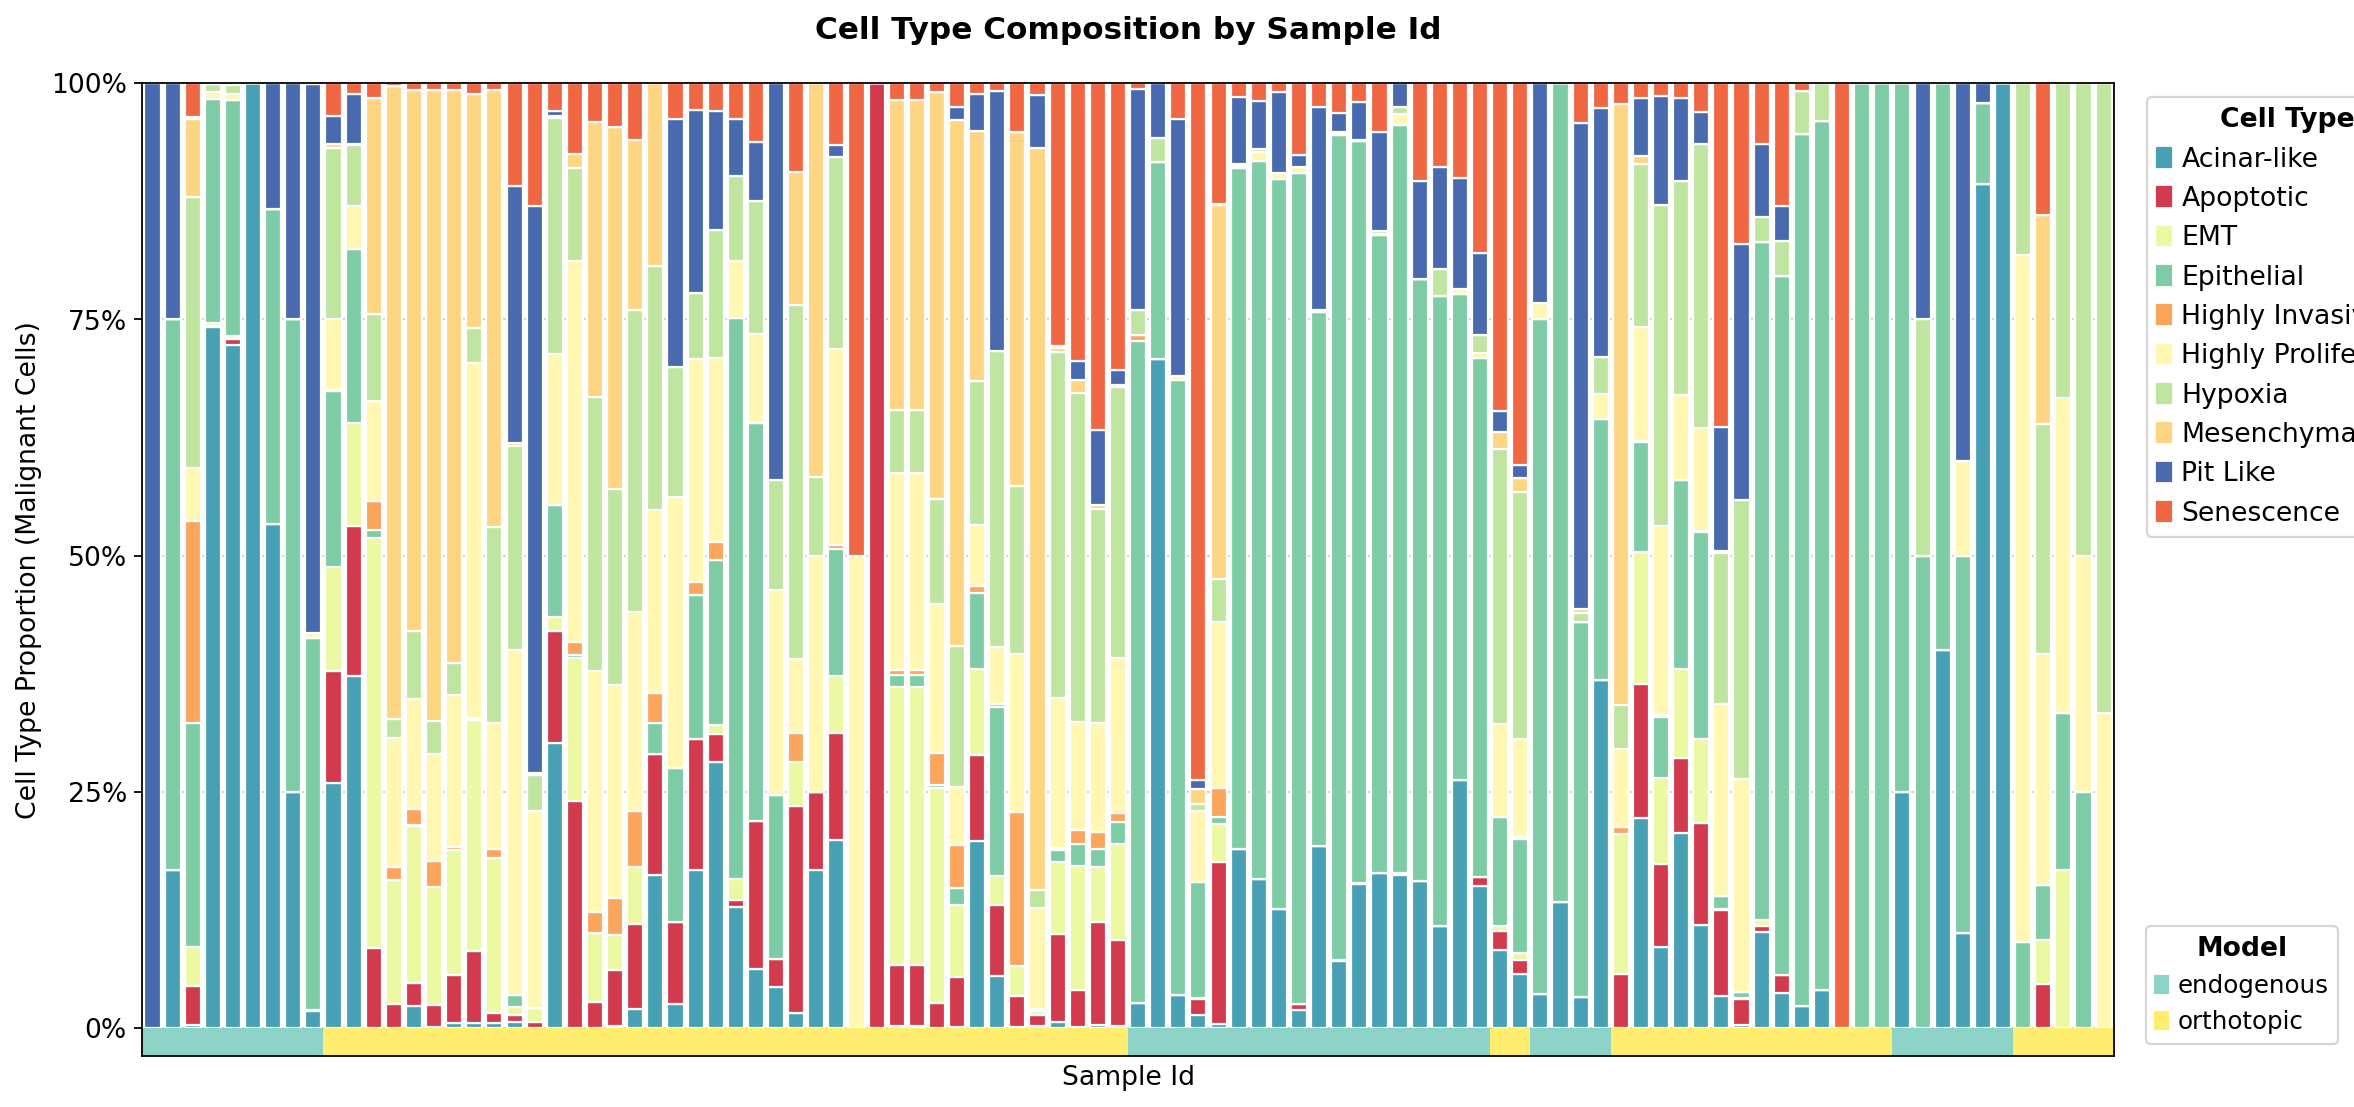

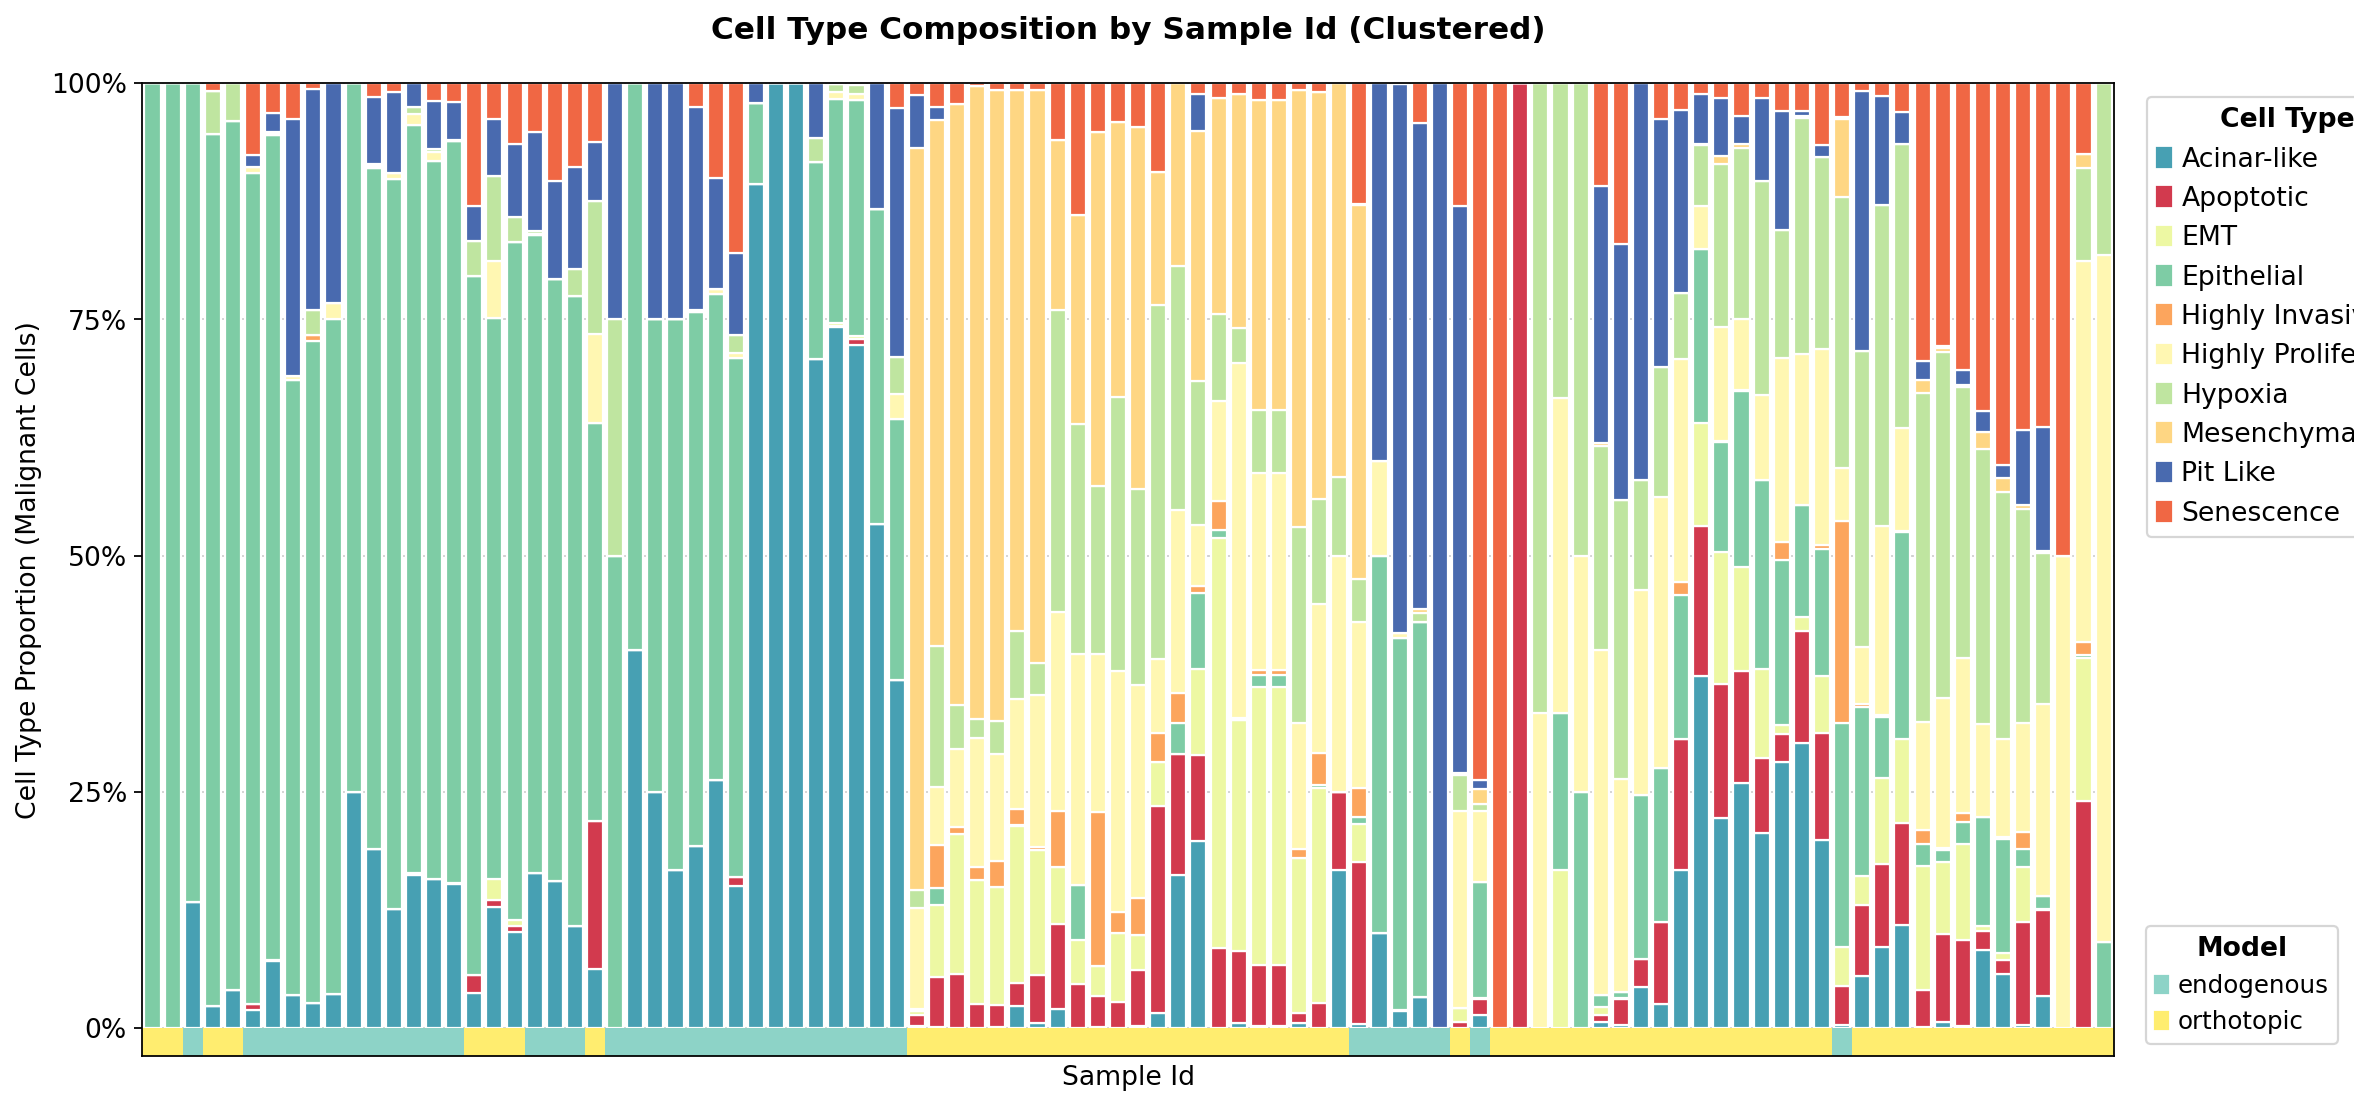

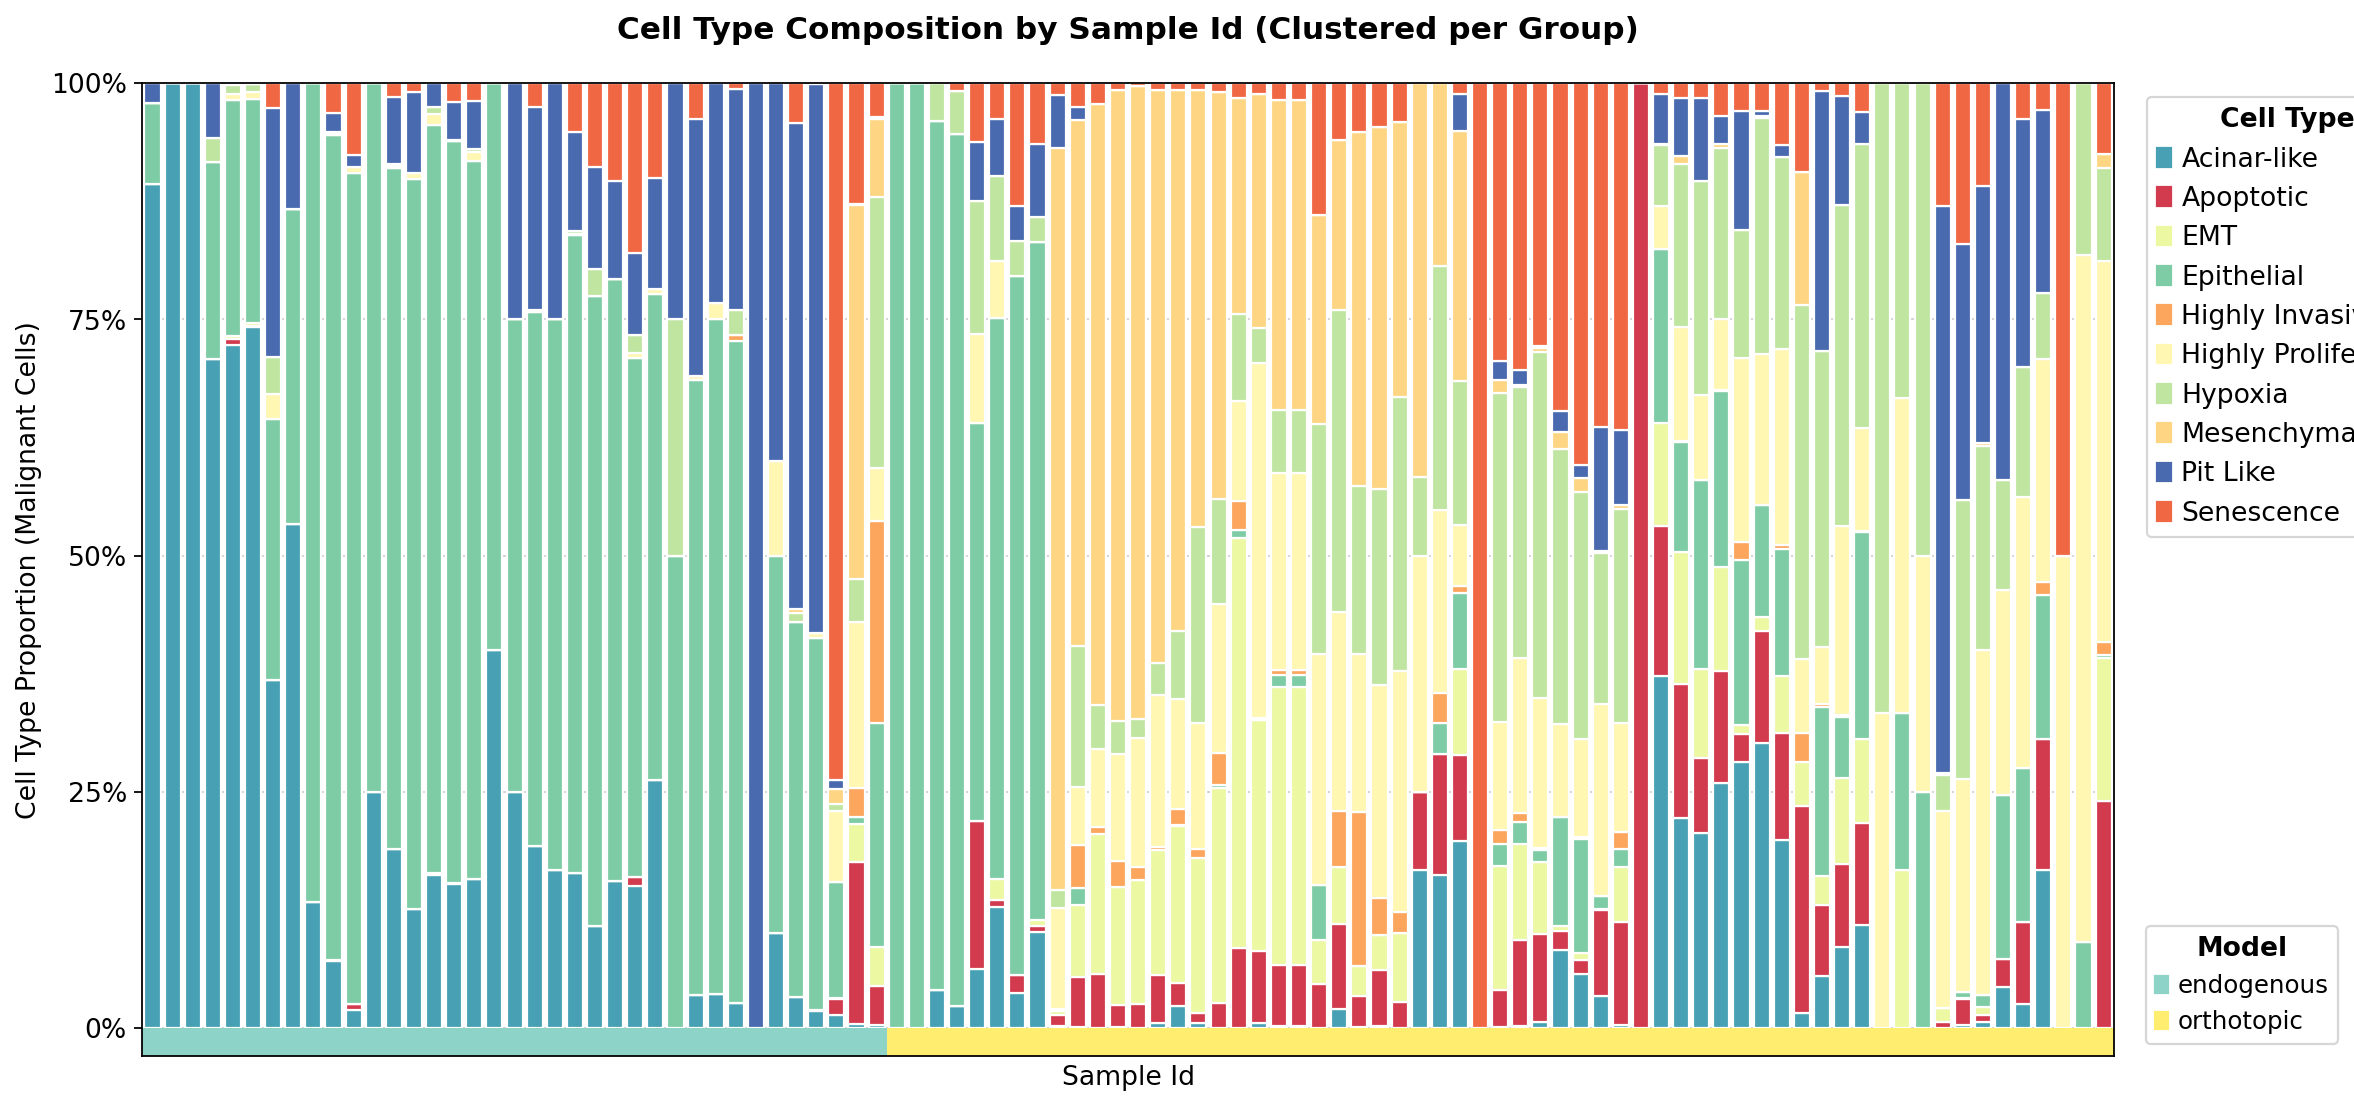

In [ ]:
fig = figgen.create_all_stacked_barplots(
    adata, 
    level_column='Level_4',
    subset_level='Level_2',
    subset_value="Malignant Cell",
    order_by_column='Model',
    save_name_prefix='malignant_cells_composition'
)

Subset to 129233 cells with Level_2 in ['Malignant Cell']
Figure saved to: /mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/figure5/compositional_plot/malignant_cells_composition_heatmap.png


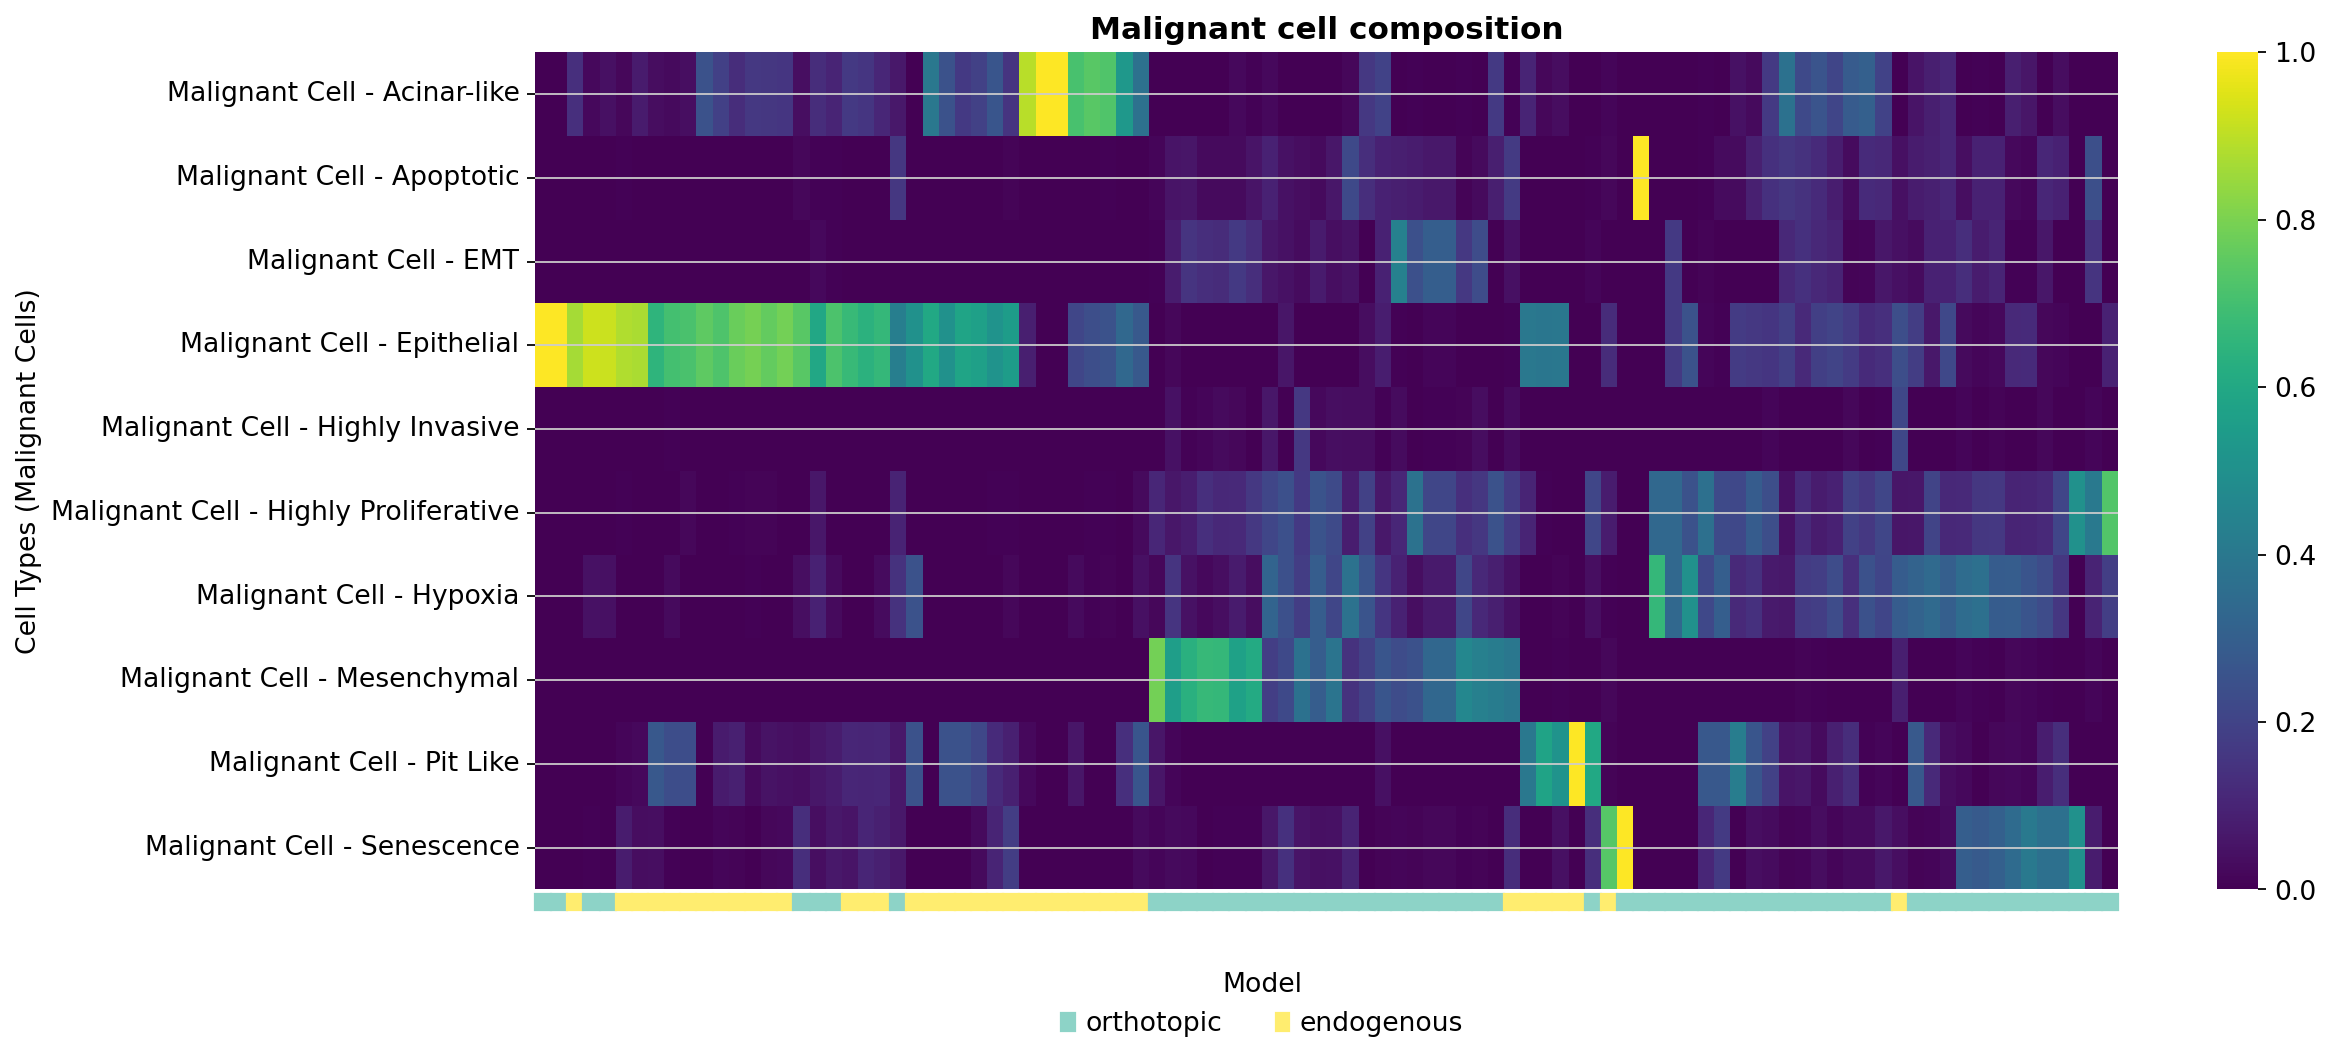

In [ ]:
fig = figgen.composition_heatmap(
        adata, 
    level_column='Level_4',
    subset_level='Level_2',
    subset_value="Malignant Cell",
    order_by_column='Model',
    title='Malignant cell composition',
    save_name='malignant_cells_composition_heatmap'
)

In [ ]:
sc.settings.figdir = "/mnt/kkf2/Cell/AG-Saur/KKF2/Daniele/pdac_atlas_figures/figure5"

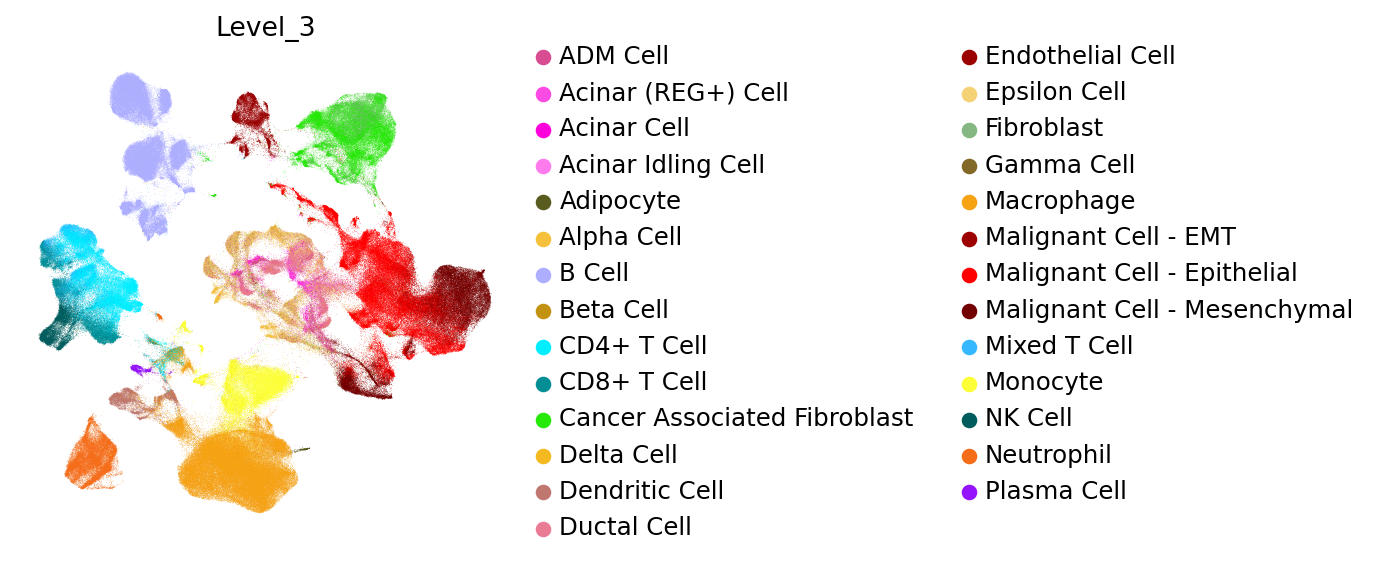

<Axes: title={'center': 'Level_3'}, xlabel='UMAP1', ylabel='UMAP2'>

In [ ]:
sc.pl.umap(adata,color="Level_3",frameon=False,palette=figgen.config["palettes"]["level_3"],save="_level3_coloured.png")
sc.pl.umap(adata,color="Level_3",frameon=False,legend_loc=None,show=False,palette=figgen.config["palettes"]["level_3"],save="_level3_coloured_nolegend.png")

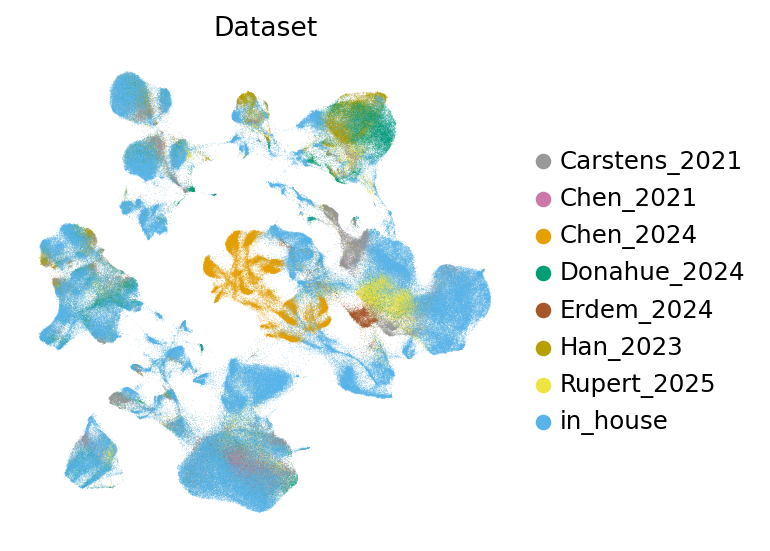

<Axes: title={'center': 'Dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

In [ ]:
sc.pl.umap(adata,color="Dataset",palette=figgen.config["palettes"]["Dataset"],frameon=False,save="_Dataset_coloured.png")
sc.pl.umap(adata,color="Dataset",palette=figgen.config["palettes"]["Dataset"],frameon=False,legend_loc=None,show=False,save="_Dataset_coloured_nolegend.png")

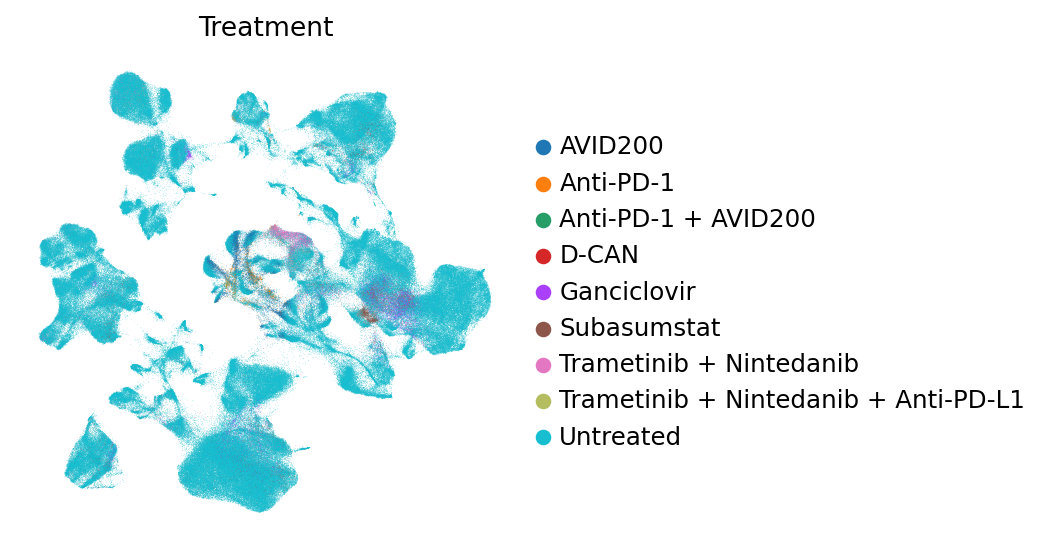

<Axes: title={'center': 'Treatment'}, xlabel='UMAP1', ylabel='UMAP2'>

In [ ]:
sc.pl.umap(adata,color="Treatment",frameon=False,save="_treatment_coloured.png")
sc.pl.umap(adata,color="Treatment",frameon=False,legend_loc=None,show=False,save="_Treatment_coloured_nolegend.png")

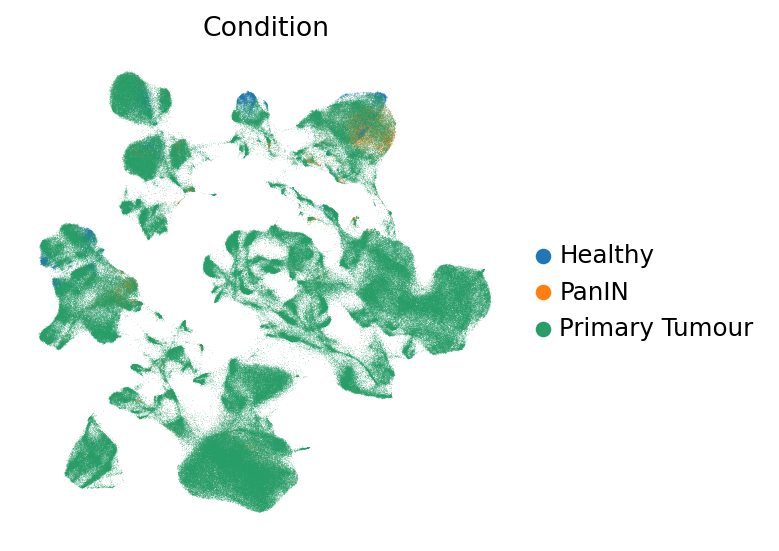

<Axes: title={'center': 'Condition'}, xlabel='UMAP1', ylabel='UMAP2'>

In [ ]:
sc.pl.umap(adata,color="Condition",frameon=False,save="_Condition_coloured.png")
sc.pl.umap(adata,color="Condition",frameon=False,legend_loc=None,show=False,save="_Condition_coloured_nolegend.png")

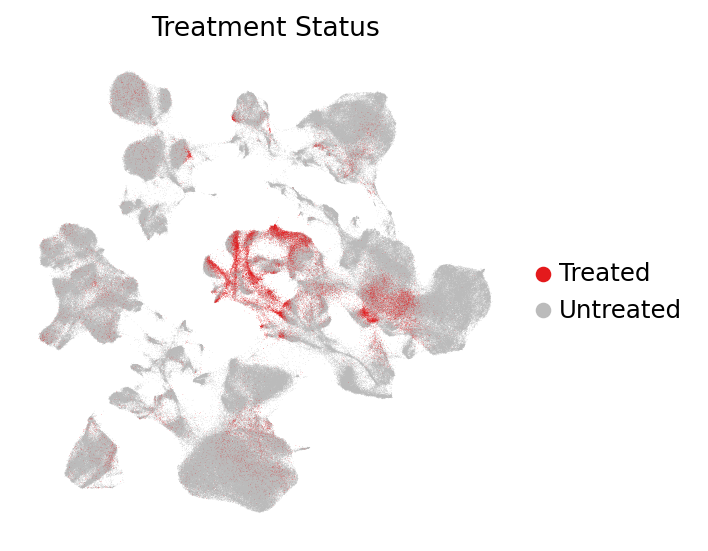

<Axes: title={'center': 'Treatment Status'}, xlabel='UMAP1', ylabel='UMAP2'>

In [ ]:
sc.pl.umap(adata,color="TreatmentStatus",palette=figgen.config["palettes"]["TreatmentStatus"],title="Treatment Status",frameon=False,save="_TreatmentStatus_coloured.png")
sc.pl.umap(adata,color="TreatmentStatus",palette=figgen.config["palettes"]["TreatmentStatus"],title="Treatment Status",frameon=False,legend_loc=None,show=False,save="_Condition_coloured_nolegend.png")

KeyError: 'orthotopic'

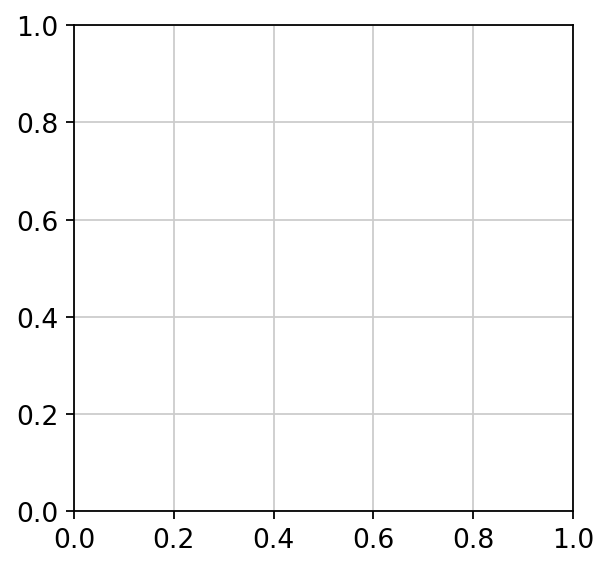

In [ ]:
sc.pl.umap(adata,color="Model",palette=figgen.config["palettes"]["Model"],title="Model",frameon=False,save="_Model_coloured.png")
sc.pl.umap(adata,color="Model",palette=figgen.config["palettes"]["Model"],title="Model",frameon=False,legend_loc=None,show=False,save="_Model_coloured_nolegend.png")